In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

time: 3.13 s


In [3]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

time: 1.33 s


In [4]:
data = pd.read_csv('./review.csv')
print(data.shape)

(6685900, 9)
time: 2min 13s


In [5]:
data.sample(5)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
6392908,02ooNKJDjsE50KfmL0Rqdw,0,2017-06-02 05:58:34,0,eHfR_ItN52BZ3WjubYdUtQ,1.0,Tonight at 9:12pm I drove about half mile from...,0,JRrYdtdd1G0kdHbDliPQGw
5538702,X3W-ddwbnZ2uAyYOxcYu3A,0,2013-10-11 14:23:09,0,0qlSfKZ_ptiaZl7dd8WRBg,5.0,Time for a review update. Over the past few y...,0,QJI9OSEn6ujRCtrX06vs1w
3888716,XvTBQotmJpVPjPNaMM7qLA,1,2010-03-05 15:10:19,1,bxZvv6pnM2dAMsqvvDOQtA,1.0,Not a fan of this particular location - I thin...,1,Y9H4ZSbAUthSMR7hB1HKsg
4096036,Xp6ogw-SCNK28s1I0fhUXw,0,2015-04-04 03:39:27,0,zp81-8QahYBM-z9RtprOcA,4.0,I was sold when I saw fresh mushrooms rather t...,0,H4tAHO1rETfWtqcjPUuk1A
2542168,BT5CAwvOSYMsfBN8KCZaNQ,0,2018-05-05 22:39:49,0,l77NbGLdoMx6an-ydMEPvA,5.0,Gelato spot hit the spot on this 102 degree da...,2,1zHr8MWy6qDcq7ZUZ4UlHA


time: 685 ms


In [6]:
df = data.loc[:,['text', 'stars','cool','funny','useful']]

time: 516 ms


In [7]:
df.sample(5)

,text,stars,cool,funny,useful
2623914,Service was poor and food was alright and a li...,2.0,0,0,0
5939732,Very happy with this taco shop and would defin...,4.0,1,0,1
1216630,Still a strange concept to order a burger for ...,4.0,0,0,0
1723708,Do not do business with this agent. ! I have ...,1.0,0,0,5
1153637,My husband and I got serious food poisoning th...,1.0,0,0,0


time: 585 ms


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 5 columns):
text      object
stars     float64
cool      int64
funny     int64
useful    int64
dtypes: float64(1), int64(3), object(1)
memory usage: 255.0+ MB
time: 10.9 ms


In [9]:
df.stars.mean()

3.7161993149762935

time: 25.6 ms


Text(0.5, 1.0, 'CountPlot')

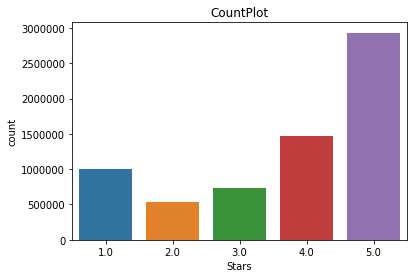

time: 1.43 s


In [10]:
sns.countplot(df.stars)
plt.xlabel('Stars')
plt.title('CountPlot')

In [11]:
result = pd.concat([df.isnull().sum(),df.isnull().mean()*100],axis=1)
result = result.rename(index=str,columns={0:'Missing count',1:'Missing %'})
result.head()

,Missing count,Missing %
text,2,0.00003
stars,0,0.00000
cool,0,0.00000
funny,0,0.00000
useful,0,0.00000


time: 4.18 s


In [12]:
df = df.dropna()

time: 5.26 s


In [13]:
df_t = df.iloc[:1000,:]

time: 7.65 ms


In [14]:
result = pd.concat([df.isnull().sum(),df.isnull().mean()*100],axis=1)
result = result.rename(index=str,columns={0:'Missing count',1:'Missing %'})
result.head()

,Missing count,Missing %
text,0,0.0
stars,0,0.0
cool,0,0.0
funny,0,0.0
useful,0,0.0


time: 4.9 s


In [15]:
df_t.stars = df_t.stars.map({5:1,4:1,3:1,2:-1,1:-1})

time: 92.9 ms


C:\Users\saiha\Anaconda3\lib\site-packages\pandas\core\generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
df_t.head()

,text,stars,cool,funny,useful
0,Total bill for this horrible service? Over $8G...,-1,0,1,6
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,0,0,0
2,I have to say that this office really has it t...,1,0,0,3
3,Went in for a lunch. Steak sandwich was delici...,1,0,0,0
4,Today was my second out of three sessions I ha...,-1,0,0,7


time: 32.2 ms


### Data preprocessing

1. Lemmetization
2. Stop words removal
3. Remove punctuations
4. Converting uppercase words to lowercase

In [17]:
def clean_text(text):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    return text

time: 10.3 ms


In [18]:
#clean_t = []
#for i, row in df.iterrows():
#    clean_t.append(clean_text(row['text']))
#df['text'] = pd.Series(clean_text)

time: 1.07 ms


In [21]:
df_t['text'] = df_t.loc[:,'text'].apply(clean_text)

time: 661 ms


C:\Users\saiha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_t.head()

,text,stars,cool,funny,useful
0,total bill horrible service 8gs crooks actuall...,-1,0,1,6
1,adore travis hard rock new kelly cardenas salo...,1,0,0,0
2,say office really together organized friendly ...,1,0,0,3
3,went lunch steak sandwich delicious caesar sal...,1,0,0,0
4,today second three sessions paid although firs...,-1,0,0,7


time: 9.97 ms
